# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다.

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=16887970fe6c0302ec714ebfd783a60d7b35082d1a64c057734655d7d75ca7e7
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121753 files and directories currently installed.)
Preparing to u

In [2]:
# catboost 설치
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.7 MB/s eta 0:00:00


In [5]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

#optuna
from optuna import Trial, create_study

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from optuna import Trial, create_study

## 2. Data Load

#### 2.1. 데이터 로드

In [7]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/train.csv'
test_path  = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/test.csv'
#rate_path  = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/base_rate.csv'
#gdp_path   = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/gdp.csv'
#population_path = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/population.csv'
xy_path = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/xy결측치 제거.csv'
train_area_path = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/dt_train_add_data_역세권.csv'
test_area_path = '/content/drive/MyDrive/Colab Notebooks/machine learning project/data/dt_test_add_data_역세권.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
#dt_rate = pd.read_csv(rate_path)
#dt_gdp = pd.read_csv(gdp_path)
#dt_population = pd.read_csv(population_path)
dt_xy = pd.read_csv(xy_path)
dt_train_area = pd.read_csv(train_area_path)
dt_test_area = pd.read_csv(test_area_path)

In [8]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [ ]:
dt_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9270 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9262 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   

In [ ]:
dt_train_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 47 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0.1           1118822 non-null  int64  
 1   Unnamed: 0             1118822 non-null  int64  
 2   번지                     1118822 non-null  object 
 3   본번                     1118822 non-null  float64
 4   부번                     1118822 non-null  float64
 5   아파트명                   1117002 non-null  object 
 6   전용면적                   1118822 non-null  float64
 7   계약년월                   1118822 non-null  int64  
 8   계약일                    1118822 non-null  int64  
 9   층                      1118822 non-null  int64  
 10  건축년도                   1118822 non-null  int64  
 11  도로명                    1118822 non-null  object 
 12  좌표X                    1118519 non-null  float64
 13  좌표Y                    1118519 non-null  float64
 14  target            

# EDA

<Axes: xlabel='target', ylabel='Count'>

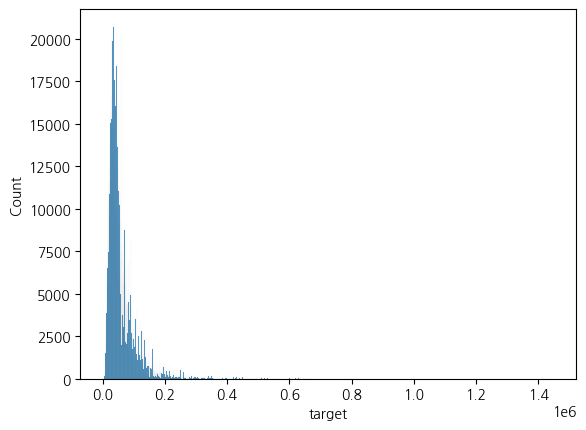

In [11]:
# sns.plotsize=(12,6)
sns.histplot(data=dt, x='target')

<Axes: xlabel='건축년도', ylabel='Count'>

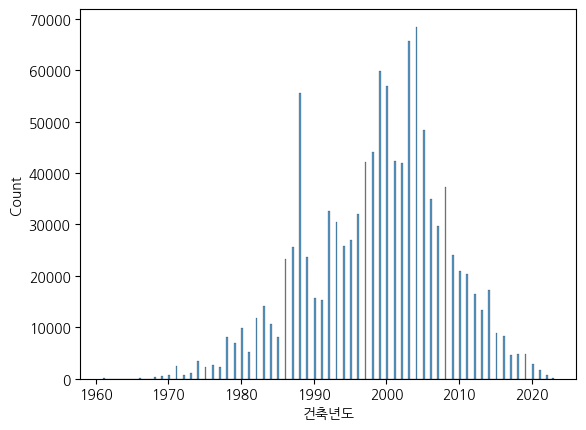

In [42]:
sns.plotsize=(12,6)
sns.histplot(data=dt, x='건축년도')

<Axes: xlabel='건축년도', ylabel='target'>

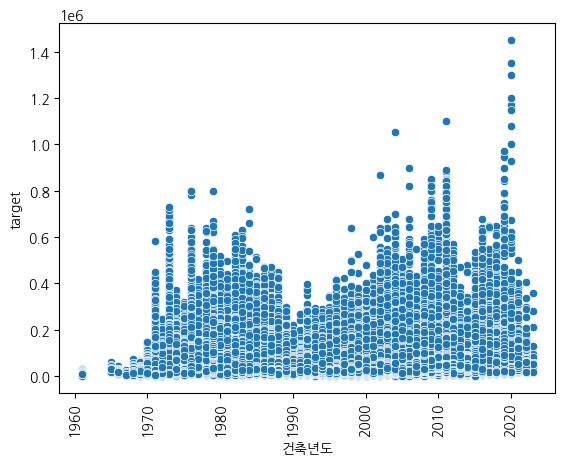

In [43]:

sns.plotsize=(12,6)
plt.xticks(rotation=90)
sns.scatterplot(data=dt, x='건축년도', y='target')

<Axes: xlabel='전용면적(㎡)', ylabel='Count'>

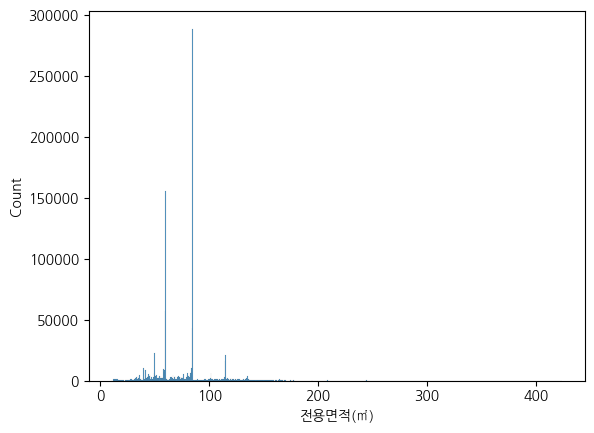

In [12]:
sns.plotsize=(12,6)
sns.histplot(data=dt, x='전용면적(㎡)')

<Axes: xlabel='전용면적(㎡)', ylabel='target'>

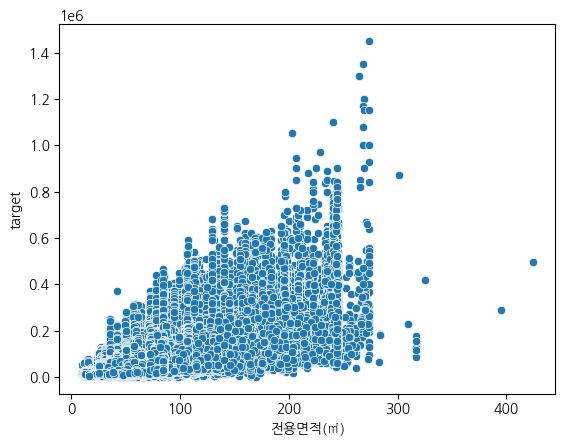

In [ ]:

sns.plotsize=(15,15)
sns.scatterplot(data=dt, x='전용면적(㎡)',y='target' )

<Axes: xlabel='층', ylabel='Count'>

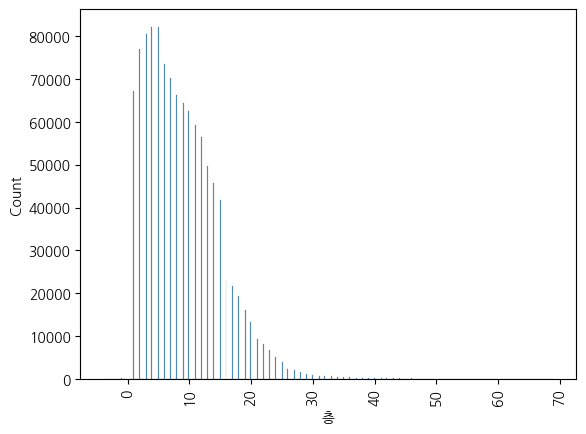

In [41]:
plt.xticks(rotation=90)
sns.plotsize=(12,6)
sns.histplot(data=dt, x='층')

<Axes: xlabel='층', ylabel='target'>

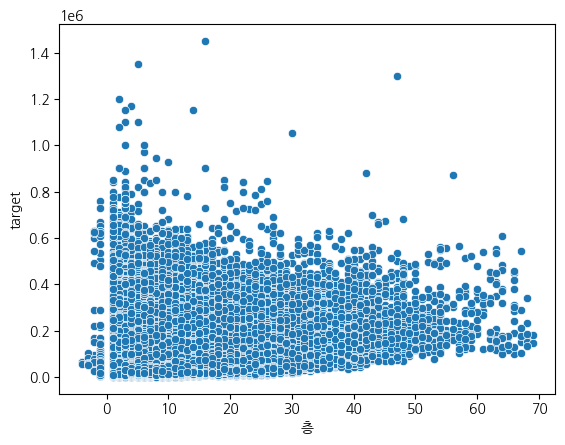

In [ ]:

sns.plotsize=(12,6)
sns.scatterplot(data=dt, x='층', y='target')

<Axes: xlabel='층', ylabel='전용면적(㎡)'>

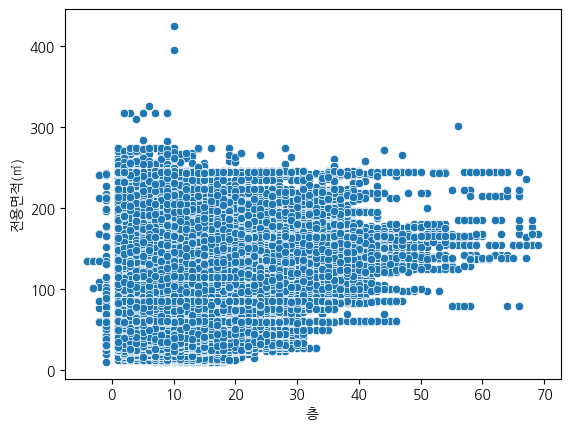

In [ ]:

sns.plotsize=(12,6)
sns.scatterplot(data=dt, x='층', y='전용면적(㎡)')

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [13]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [ ]:
dt_train_area['is_test'] = 0
dt_test_area['is_test'] = 1
concat = pd.concat([dt_train_area, dt_test_area])     # 하나의 데이터로 만들어줍니다.


In [ ]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [17]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  16823 non-null    object 
 13  거래유형                    41643 non-null    object 
 14  중개사소재

In [ ]:
concat = concat.drop(columns=['Unnamed: 0.1','Unnamed: 0','좌표X','좌표Y'])

concat.info()

In [14]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### xy 좌표추가(네이버 api)

In [ ]:
dt_xy

,위도,경도,n도로명
0,37.476339,127.057140,언주로 3
1,37.496405,127.077126,개포로109길 69
2,37.487802,127.068028,삼성로4길 17
3,37.488632,127.070442,개포로 516
4,37.514814,127.038310,언주로130길 30
...,...,...,...
2850,37.603390,127.098120,봉화산로56길 123
2851,37.614582,127.093807,신내로17길 41
2852,37.613640,127.095068,신내로 155
2853,37.594530,127.075916,중랑천로14길 58


In [ ]:
dt_xy = dt_xy.drop(columns=['Unnamed: 0','Unnamed: 0.1','도로명'])
dt_xy

,위도,경도,n도로명
0,37.476339,127.057140,언주로 3
1,37.496405,127.077126,개포로109길 69
2,37.487802,127.068028,삼성로4길 17
3,37.488632,127.070442,개포로 516
4,37.514814,127.038310,언주로130길 30
...,...,...,...
2850,37.603390,127.098120,봉화산로56길 123
2851,37.614582,127.093807,신내로17길 41
2852,37.613640,127.095068,신내로 155
2853,37.594530,127.075916,중랑천로14길 58


In [ ]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '기준금리', '미국기준금리', 'GDP', '가계신용금액',
       '가계대출금액', '판매신용금액', '본원통화(말잔,계절조정계열)', '현금통화', '중앙은행 대 예금취급기관부채',
       '대출평균 1) (연%)', '기업대출 (연리%)', '대기업대출 (연리%)', '중소기업대출 (연리%)',
       '운전자금대출 (연리%)', '시설자금대출 (연리%)', '상업어음할인 (연리%)', '기업일반자금대출 (연리%)',
       '가계대출 (연리%)', '소액대출 (500만원 이하) (연리%)', '주택담보대출 (연리%)',
       '고정형 주택담보대출 (연리%)', '변동형 주택담보대출 (연리%)', '예・적금담보대출 (연리

In [ ]:
concat[['좌표X','좌표Y','도로명']]

,좌표X,좌표Y,도로명
0,127.057210,37.476763,언주로 3
1,127.058521,37.480002,개포로 310
2,127.058521,37.480002,개포로 310
3,127.048985,37.493029,선릉로 221
4,127.065070,37.497741,삼성로 212
...,...,...,...
9267,NaN,NaN,문래로 94-7
9268,NaN,NaN,대방천로 180
9269,126.926774,37.616604,진흥로 265
9270,NaN,NaN,강남대로53길 11


In [ ]:

dt_xy.rename(columns={'n도로명':'도로명'}, inplace=True)
dt_xy

,위도,경도,도로명
0,37.476339,127.057140,언주로 3
1,37.496405,127.077126,개포로109길 69
2,37.487802,127.068028,삼성로4길 17
3,37.488632,127.070442,개포로 516
4,37.514814,127.038310,언주로130길 30
...,...,...,...
2850,37.603390,127.098120,봉화산로56길 123
2851,37.614582,127.093807,신내로17길 41
2852,37.613640,127.095068,신내로 155
2853,37.594530,127.075916,중랑천로14길 58


In [ ]:
# '도로명'을 기준으로 concat과 dt_xy를 병합
merged_df = pd.merge(concat, dt_xy, on='도로명', how='left')

# '좌표X'와 '좌표Y' 칼럼의 NaN 값을 '경도'와 '위도' 칼럼의 값으로 대체
merged_df['좌표X'].fillna(merged_df['경도'], inplace=True)
merged_df['좌표Y'].fillna(merged_df['위도'], inplace=True)

# '경도'와 '위도' 칼럼 삭제
merged_df = merged_df.drop(columns=['경도', '위도'])

merged_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,주택담보대출 (연리%),고정형 주택담보대출 (연리%),변동형 주택담보대출 (연리%),예・적금담보대출 (연리%),보증대출 (연리%),전세자금대출 (연리%),일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%),is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,201712,8,3,1987,...,3.42,3.46,3.37,3.01,3.49,3.20,4.38,3.52,2.96,0
1,서울특별시 강남구 개포동,141,141.0,0.0,개포주공1단지,58.0800,201712,8,4,1982,...,3.42,3.46,3.37,3.01,3.49,3.20,4.38,3.52,2.96,0
2,서울특별시 강남구 개포동,141,141.0,0.0,개포주공1단지,50.6400,201712,8,2,1982,...,3.42,3.46,3.37,3.01,3.49,3.20,4.38,3.52,2.96,0
3,서울특별시 강남구 도곡동,527,527.0,0.0,도곡렉슬,119.8906,201712,8,16,2006,...,3.42,3.46,3.37,3.01,3.49,3.20,4.38,3.52,2.96,0
4,서울특별시 강남구 대치동,316,316.0,0.0,은마,84.4300,201712,8,13,1979,...,3.42,3.46,3.37,3.01,3.49,3.20,4.38,3.52,2.96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135355,서울특별시 영등포구 문래동3가,93-1,93.0,1.0,문래건영,59.4000,202309,25,11,1998,...,4.35,4.30,4.51,5.13,5.06,4.18,6.59,4.26,5.33,1
1135356,서울특별시 영등포구 신길동,4518,4518.0,0.0,우성2,84.4700,202309,25,11,1986,...,4.35,4.30,4.51,5.13,5.06,4.18,6.59,4.26,5.33,1
1135357,서울특별시 은평구 불광동,637,637.0,0.0,북한산래미안,59.9932,202309,25,11,2010,...,4.35,4.30,4.51,5.13,5.06,4.18,6.59,4.26,5.33,1
1135358,서울특별시 서초구 서초동,1330,1330.0,0.0,서초동삼성쉐르빌2,35.1700,202309,26,7,2002,...,4.35,4.30,4.51,5.13,5.06,4.18,6.59,4.26,5.33,1


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135360 entries, 0 to 1135359
Data columns (total 81 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1135360 non-null  object 
 1   번지                      1135133 non-null  object 
 2   본번                      1135285 non-null  float64
 3   부번                      1135285 non-null  float64
 4   아파트명                    1133224 non-null  object 
 5   전용면적                    1135360 non-null  float64
 6   계약년월                    1135360 non-null  int64  
 7   계약일                     1135360 non-null  int64  
 8   층                       1135360 non-null  int64  
 9   건축년도                    1135360 non-null  int64  
 10  도로명                     1135360 non-null  object 
 11  해제사유발생일                 6243 non-null     float64
 12  등기신청일자                  1135360 non-null  object 
 13  거래유형                    1135360 non-null  object 
 14  중개

In [ ]:
concat = concat.merge(dt_xy, on='도로명', how='inner')
display(concat.info())
display(concat[['좌표X','좌표Y','위도','경도','도로명']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874374 entries, 0 to 874373
Data columns (total 83 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   시군구                     874374 non-null  object 
 1   번지                      874222 non-null  object 
 2   본번                      874374 non-null  float64
 3   부번                      874374 non-null  float64
 4   아파트명                    874140 non-null  object 
 5   전용면적                    874374 non-null  float64
 6   계약년월                    874374 non-null  int64  
 7   계약일                     874374 non-null  int64  
 8   층                       874374 non-null  int64  
 9   건축년도                    874374 non-null  int64  
 10  도로명                     874374 non-null  object 
 11  해제사유발생일                 4889 non-null    float64
 12  등기신청일자                  14856 non-null   object 
 13  거래유형                    35222 non-null   object 
 14  중개사소재지              

None

KeyError: ('x', 'y', '위도', '경도', '도로명')

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 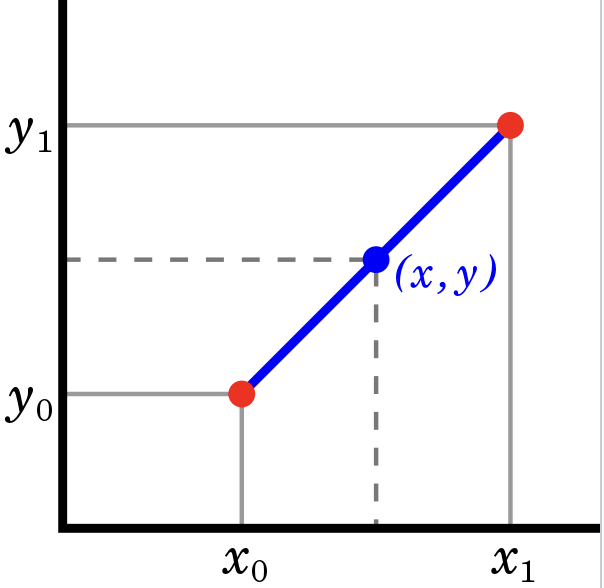

In [ ]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [ ]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [ ]:
display(concat['중개사소재지'].value_counts())

-                          1090013
서울 노원구                        2627
서울 송파구                        2540
서울 강남구                        2508
서울 강동구                        2038
                            ...   
부산 해운대구, 서울 강남구, 서울 용산구          1
경기 의정부시, 서울 영등포구                 1
서울 노원구, 서울 양천구                   1
광주 동구, 서울 노원구                    1
경기 연천군, 서울 송파구                   1
Name: 중개사소재지, Length: 739, dtype: int64

In [15]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [ ]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

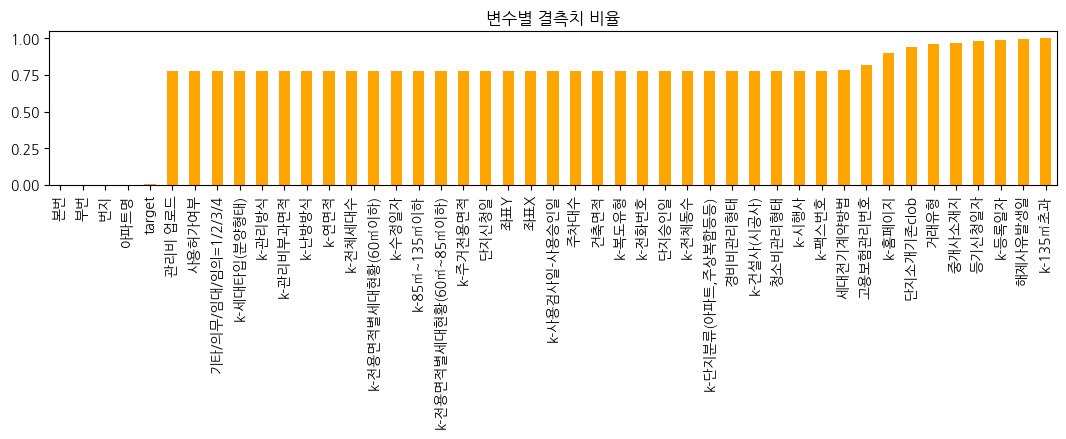

In [16]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [18]:
# Null값이 110만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 110만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 850000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 110만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 850000]))

* 결측치가 110만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test']
* 결측치가 110만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']


In [19]:
# 위에서 결측치가 110만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 850000])
concat_select = concat[selected]

In [20]:
concat_select.isnull().sum()     # 결측치가 110만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

In [21]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   번지       1127867 non-null  object 
 2   본번       1128019 non-null  float64
 3   부번       1128019 non-null  float64
 4   아파트명     1125958 non-null  object 
 5   전용면적     1128094 non-null  float64
 6   계약년월     1128094 non-null  int64  
 7   계약일      1128094 non-null  int64  
 8   층        1128094 non-null  int64  
 9   건축년도     1128094 non-null  int64  
 10  도로명      1128094 non-null  object 
 11  target   1118822 non-null  float64
 12  is_test  1128094 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 120.5+ MB


In [22]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [23]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명']


In [ ]:
concat_select[categorical_columns]

,시군구,번지,본번,부번,아파트명,도로명
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,언주로 3
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,언주로 3
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,언주로 3
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,언주로 3
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,언주로 3
...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,신내역로1길 85
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,신내역로1길 85
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,신내역로1길 85
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,신내역로1길 85


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [24]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [25]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구        0
번지         0
본번         0
부번         0
아파트명       0
전용면적       0
계약년월       0
계약일        0
층          0
건축년도       0
도로명        0
target     0
is_test    0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

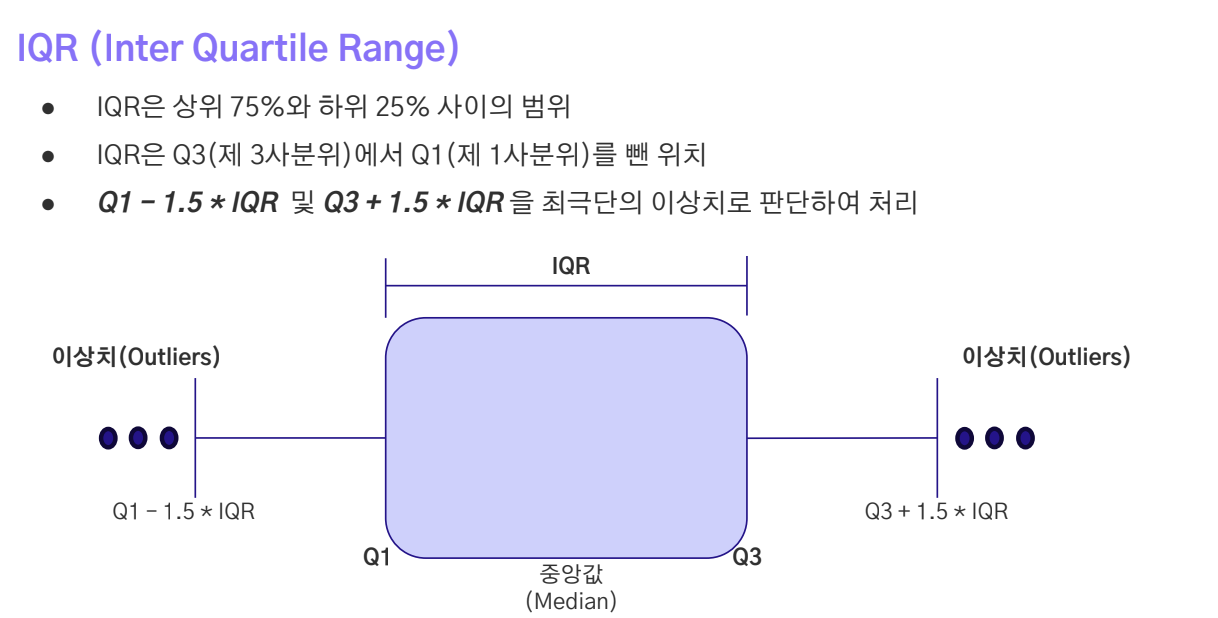

In [ ]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 41)


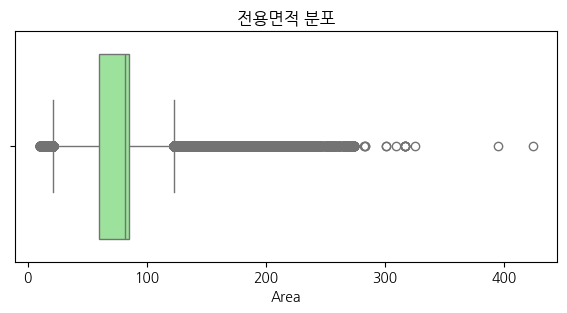

In [ ]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [ ]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [ ]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [ ]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(981501, 49)


In [ ]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    972229
1      9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [26]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']



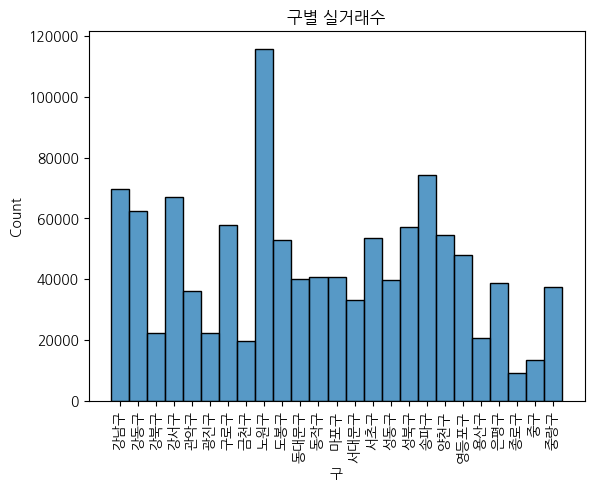

In [37]:
sns.histplot(data = concat_select, x = '구')
plt.title('구별 실거래수')
plt.xticks(rotation=90)
plt.show()

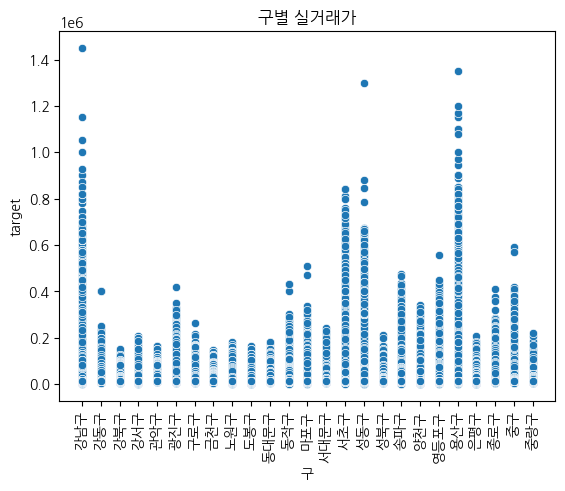

In [28]:
sns.scatterplot(data = concat_select, x = '구', y = 'target')
plt.title('구별 실거래가')
plt.xticks(rotation=90)
plt.show()

In [29]:
concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [33]:
concat_select_sort = concat_select.sort_values(by=['계약년'])

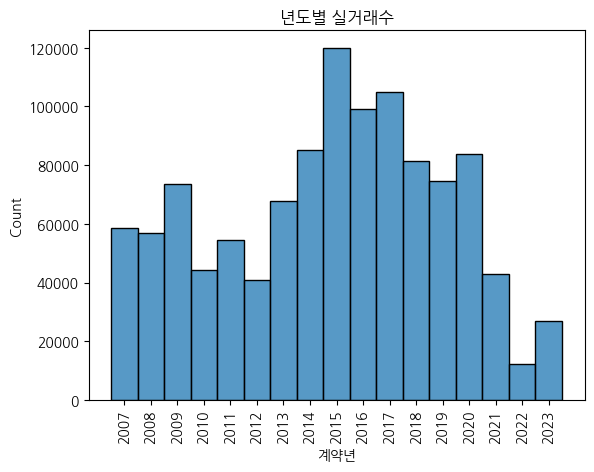

In [35]:
sns.histplot(data = concat_select_sort, x = '계약년')
plt.title('년도별 실거래수')
plt.xticks(rotation=90)
plt.show()

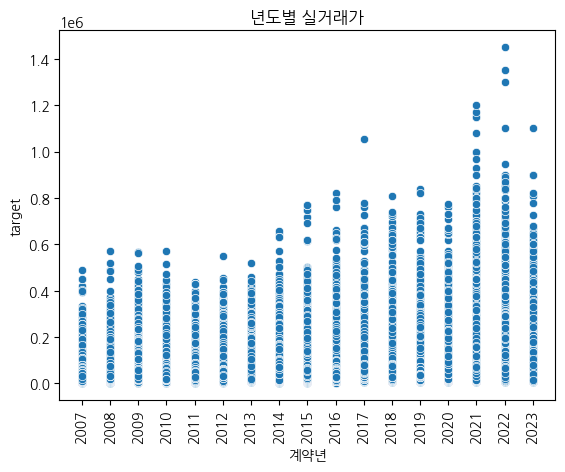

In [36]:
sns.scatterplot(data = concat_select_sort, x = '계약년', y = 'target')
plt.title('년도별 실거래가')
plt.xticks(rotation=90)
plt.show()

In [ ]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target',
       '역세권_여부', '구', '강남여부', '신축여부', '기준금리', '미국기준금리', 'GDP', '가계신용금액',
       '가계대출금액', '판매신용금액', '본원통화(말잔,계절조정계열)', '현금통화', '중앙은행 대 예금취급기관부채',
       '대출평균 1) (연%)', '기업대출 (연리%)', '대기업대출 (연리%)', '중소기업대출 (연리%)',
       '운전자금대출 (연리%)', '시설자금대출 (연리%)', '상업어음할인 (연리%)', '기업일반자금대출 (연리%)',
       '가계대출 (연리%)', '소액대출 (500만원 이하) (연리%)', '주택담보대출 (연리%)',
       '고정형 주택담보대출 (연리%)', '변동형 주택담보대출 (연리%)', '예・적금담보대출 (연리%)', '보증대출 (연리%)',
       '전세자금대출 (연리%)', '일반신용대출 2) (연리%)', '집단대출 2) (연리%)', '공공및기타부문대출 (연리%)',
       'is_test', '고층여부', '전용면적_under_60', '전용면적_60_85', '전용면적_85_135',
       '전용면적_over_135', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [38]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [39]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만듭니다.
concat_select['강남여부'] = is_gangnam

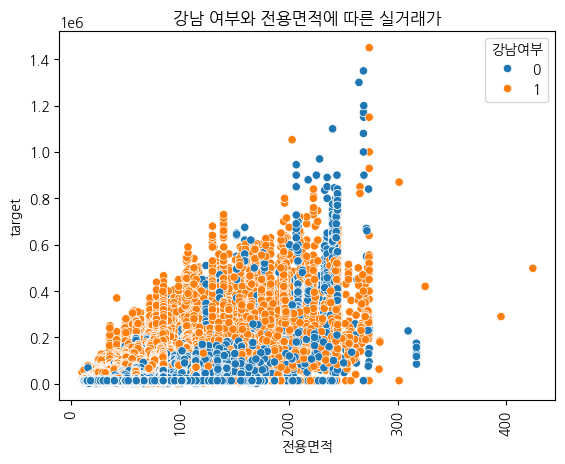

In [40]:
sns.scatterplot(data = concat_select, x = '전용면적', y = 'target',hue='강남여부')
plt.title('강남 여부와 전용면적에 따른 실거래가')
plt.xticks(rotation=90)
plt.show()

In [ ]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [ ]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.128094e+06
mean     1.998791e+03
std      9.358540e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [ ]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [ ]:
# 20층 이상이면 고층이라고 판단해서 고층여부 변수 제작
concat_select['고층여부'] = concat_select['층'].apply(lambda x: 1 if x >= 20 else 0)

In [ ]:
# 전용면적을 구간별로 분리하는 변수 제작
concat_select['전용면적_under_60'] = (concat_select['전용면적'] <= 60).astype(int)
concat_select['전용면적_60_85'] = ((concat_select['전용면적'] > 60) & (concat_select['전용면적'] <= 85)).astype(int)
concat_select['전용면적_85_135'] = ((concat_select['전용면적'] > 85) & (concat_select['전용면적'] <= 135)).astype(int)
concat_select['전용면적_over_135'] = (concat_select['전용면적'] > 135).astype(int)
concat_select.head(10)


,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,...,전세자금대출 (연리%),일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%),is_test,고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135
0,658-1,658.0,1.0,개포6차우성,79.9700,201712,8,3,1987,언주로 3,...,3.15,4.41,3.12,3.28,0,0,0,1,0,0
1,141,141.0,0.0,개포주공1단지,58.0800,201712,8,4,1982,개포로 310,...,3.15,4.41,3.12,3.28,0,0,1,0,0,0
2,141,141.0,0.0,개포주공1단지,50.6400,201712,8,2,1982,개포로 310,...,3.15,4.41,3.12,3.28,0,0,1,0,0,0
3,527,527.0,0.0,도곡렉슬,119.8906,201712,8,16,2006,선릉로 221,...,3.15,4.41,3.12,3.28,0,0,0,0,1,0
4,316,316.0,0.0,은마,84.4300,201712,8,13,1979,삼성로 212,...,3.15,4.41,3.12,3.28,0,0,0,1,0,0
5,185,185.0,0.0,개포주공7단지,73.2600,201712,8,1,1983,개포로 516,...,3.15,4.41,3.12,3.28,0,0,0,1,0,0
6,185,185.0,0.0,개포주공7단지,73.2600,201712,8,3,1983,개포로 516,...,3.15,4.41,3.12,3.28,0,0,0,1,0,0
7,1027,1027.0,0.0,래미안대치팰리스,94.4900,201712,8,13,2015,삼성로51길 37,...,3.15,4.41,3.12,3.28,0,0,0,0,1,0
8,506,506.0,0.0,선경1차,136.6800,201712,8,5,1983,삼성로 151,...,3.15,4.41,3.12,3.28,0,0,0,0,0,1
9,511,511.0,0.0,한보미도맨션2,115.0500,201712,8,9,1985,삼성로 150,...,3.15,4.41,3.12,3.28,0,0,0,0,1,0


In [ ]:
concat_select = concat_select.drop(['전용면적','층'], axis=1)

In [ ]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,계약일,건축년도,도로명,target,역세권_여부,구,...,집단대출 2) (연리%),공공및기타부문대출 (연리%),is_test,고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,8,1987,언주로 3,124000.0,False,강남구,...,3.12,3.28,0,0,0,1,0,0,2017,12


In [ ]:
concat_select.shape

(1128094, 48)

In [ ]:
concat_select.shape

(1128094, 48)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 47) (9272, 47)


In [ ]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,...,일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%),고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,-999999999.0,...,7.21,4.79,5.2,0,0,1,0,0,2023,07


In [ ]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [ ]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,...,일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%),고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,0,...,7.21,4.79,5.2,0,0,1,0,0,2023,07


### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

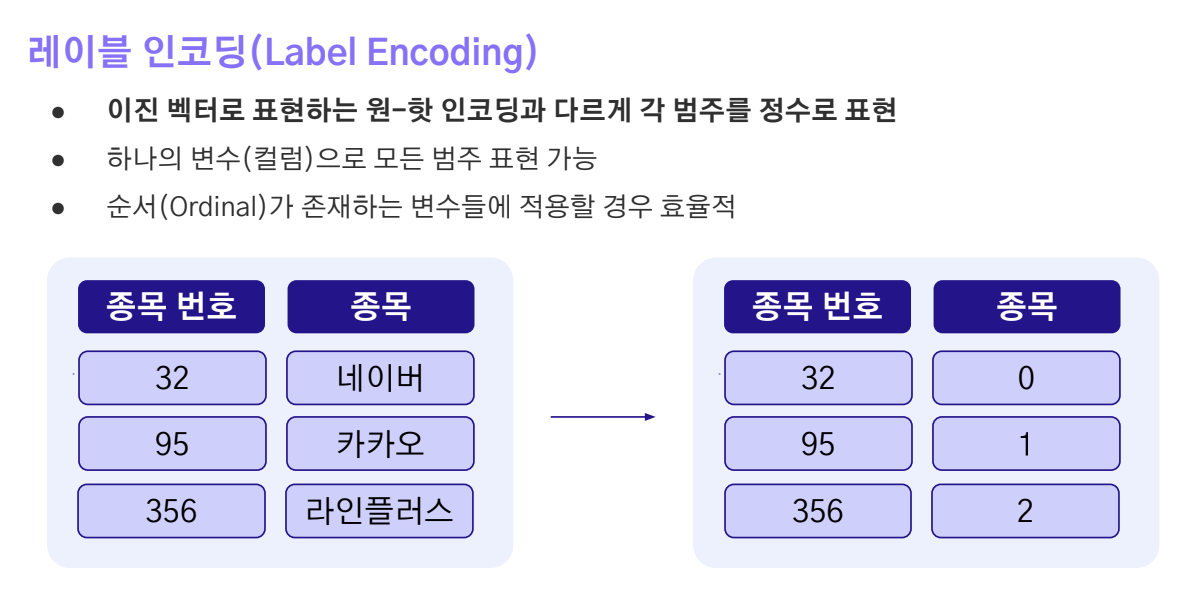

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['계약일', '건축년도', 'target', '역세권_여부', '강남여부', '신축여부', '기준금리', '미국기준금리', 'GDP', '가계신용금액', '가계대출금액', '판매신용금액', '본원통화(말잔,계절조정계열)', '현금통화', '중앙은행 대 예금취급기관부채', '대출평균 1) (연%)', '기업대출 (연리%)', '대기업대출 (연리%)', '중소기업대출 (연리%)', '운전자금대출 (연리%)', '시설자금대출 (연리%)', '상업어음할인 (연리%)', '기업일반자금대출 (연리%)', '가계대출 (연리%)', '소액대출 (500만원 이하) (연리%)', '주택담보대출 (연리%)', '고정형 주택담보대출 (연리%)', '변동형 주택담보대출 (연리%)', '예・적금담보대출 (연리%)', '보증대출 (연리%)', '전세자금대출 (연리%)', '일반신용대출 2) (연리%)', '집단대출 2) (연리%)', '공공및기타부문대출 (연리%)', '고층여부', '전용면적_under_60', '전용면적_60_85', '전용면적_85_135', '전용면적_over_135']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '구', '계약년', '계약월']


In [ ]:
dt_train[categorical_columns_v2]

,번지,본번,부번,아파트명,도로명,구,동,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,언주로 3,강남구,개포동,2017,12
1,658-1,658.0,1.0,개포6차우성,언주로 3,강남구,개포동,2017,12
2,658-1,658.0,1.0,개포6차우성,언주로 3,강남구,개포동,2017,12
3,658-1,658.0,1.0,개포6차우성,언주로 3,강남구,개포동,2018,01
4,658-1,658.0,1.0,개포6차우성,언주로 3,강남구,개포동,2018,01
...,...,...,...,...,...,...,...,...,...
1118817,382,382.0,0.0,갈현현대,서오릉로21길 36,은평구,구산동,2007,07
1118818,382,382.0,0.0,갈현현대,서오릉로21길 36,은평구,구산동,2007,08
1118819,382,382.0,0.0,갈현현대,서오릉로21길 36,은평구,구산동,2007,08
1118820,382,382.0,0.0,갈현현대,서오릉로21길 36,은평구,구산동,2007,09


In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


In [ ]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,계약일,건축년도,도로명,target,역세권_여부,구,...,일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%),고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월
0,4732,1148,1,330,8,1987,6176,124000.0,False,0,...,4.41,3.12,3.28,0,0,1,0,0,10,11


In [ ]:
dt_train['계약년']

0          10
1          10
2          10
3          10
4          10
           ..
1118817     0
1118818     0
1118819     0
1118820     0
1118821     0
Name: 계약년, Length: 1118822, dtype: int64

### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [ ]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [ ]:
dt_test['계약년'].head(1)

0    16
Name: 계약년, dtype: int64

In [ ]:
#시간에 따른 train,val 데이터 분리(계약년:2023)

train = dt_train.loc[dt_train['계약년'] != 16]
valid = dt_train.loc[dt_train['계약년'] == 16]

# Target과 독립변수들을 분리해줍니다.
y_train = train['target']
X_train = train.drop(['target'], axis=1)

y_val = valid['target']
X_val = valid.drop(['target'], axis=1)

print(train.shape,valid.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1101274, 47) (17548, 47)
(1101274, 46) (17548, 46) (1101274,) (17548,)


In [ ]:
X_val.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,동,계약년,계약월,강남여부,신축여부,고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135
201009,4707,1142,1,329,105.8064,29,8,2021,469,3,...,8,16,5,1,1,0,0,0,1,0
201010,1692,584,0,339,74.2500,3,10,1983,4481,3,...,8,16,0,1,0,0,0,1,0,0
201011,1692,584,0,339,61.1900,5,12,1983,4481,3,...,8,16,1,1,0,0,0,1,0,0
201012,1692,584,0,339,83.1700,7,13,1983,4481,3,...,8,16,3,1,0,0,0,1,0,0
201013,1692,584,0,339,83.1700,29,10,1983,4481,3,...,8,16,3,1,0,0,0,1,0,0


In [ ]:
# # Target과 독립변수들을 분리해줍니다.
# y_train = dt_train['target']
# X_train = dt_train.drop(['target'], axis=1)

# # Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [ ]:
#catboost

from catboost import CatBoostRegressor

# 모델 초기화
model = CatBoostRegressor(
    loss_function= "RMSE",                # Objective function for the model
    eval_metric= "RMSE",                  # Evaluation metric
    verbose= True,                       # Verbosity level (False for silent)
    boosting_type= "Plain",               # Gradient boosting type (for CatBoost, default is Plain)
    random_seed= 202,                     # Random seed for reproducibility

    max_depth= 9,
    learning_rate= 0.14810002488624377,
    min_child_samples= 138,
    n_estimators= 5497,
    task_type='GPU'  # GPU 사용 설정
)

# 모델 학습
model.fit(X_train, y_train)

# 예측 수행
pred = model.predict(X_val)

# 예측 결과 출력
print(pred)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
499:	learn: 9609.1673805	total: 4.83s	remaining: 48.2s
500:	learn: 9602.9264100	total: 4.83s	remaining: 48.2s
501:	learn: 9600.3623968	total: 4.84s	remaining: 48.2s
502:	learn: 9592.1147525	total: 4.85s	remaining: 48.2s
503:	learn: 9586.8404183	total: 4.86s	remaining: 48.2s
504:	learn: 9584.3424376	total: 4.87s	remaining: 48.2s
505:	learn: 9581.3465452	total: 4.88s	remaining: 48.2s
506:	learn: 9577.8502856	total: 4.89s	remaining: 48.2s
507:	learn: 9573.9171580	total: 4.9s	remaining: 48.1s
508:	learn: 9567.5393452	total: 4.91s	remaining: 48.2s
509:	learn: 9564.8575401	total: 4.92s	remaining: 48.1s
510:	learn: 9558.6390385	total: 4.93s	remaining: 48.1s
511:	learn: 9552.8299364	total: 4.94s	remaining: 48.1s
512:	learn: 9547.3252687	total: 4.96s	remaining: 48.1s
513:	learn: 9542.2500915	total: 4.96s	remaining: 48.1s
514:	learn: 9538.8385217	total: 4.97s	remaining: 48.1s
515:	learn: 9537.4357755	total: 4.99s	remaining: 48.1s
516:	learn: 9528.7635574	total

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GroupKFold



# Specify the parameters for AutoML
automl_params = {
    'loss_function': 'RMSE',
    'task_type': 'GPU',
    'iterations': 1500,
    'learning_rate': 0.085,
    'eval_metric': 'RMSE',
    'depth': 13,
    'verbose': 1,
    'od_type': 'Iter',
    'od_wait': 30,
    'random_seed': 2023,
    'allow_writing_files': False
}

# Define the group labels. For example, we can define them as the first column of X.
groups = X_train.iloc[:, 0]

# Initialize the GroupKFold object
group_kfold = GroupKFold(n_splits=5)

# Apply the split to obtain indices for training and testing sets
for train_index, val_index in group_kfold.split(X_train, y_train, groups):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize the data pools
    train_pool = Pool(X_train_fold, y_train_fold)
    val_pool = Pool(X_val_fold, y_val_fold)

    # Initialize the CatBoost model
    model = CatBoostRegressor(**automl_params)

    # Fit the model
    model.fit(train_pool,eval_set=val_pool,verbose=2)

    # Get predictions
    preds = model.predict(val_pool)
    print(preds)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    print(f"RMSE: {rmse}")




## optuna_code

#### xgboost

In [ ]:
def objective_xgb(trial: Trial, X_train: np.ndarray, y_train: np.ndarray) -> float:
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 8, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 0.8)
    reg_lambda = trial.suggest_float("reg_lambda", 0.5, 20)


    model = XGBRegressor(
        random_state = 42,
        enable_categorical=True,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        device = 'cuda',
        tree_method= 'gpu_hist'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))

    return rmse

#### light GBM

In [ ]:
def objective_lgbm(trial: Trial, X_train: np.ndarray, y_train: np.ndarray, categorical_columns_v2: list) -> float:
    n_estimators = trial.suggest_int("n_estimators", 200, 5000)
    max_depth = trial.suggest_int("max_depth", 8, 20)
    max_possible_leaves = 2 ** max_depth
    num_leaves = trial.suggest_int("num_leaves", 0, max_possible_leaves)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.3)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 0.8)
    reg_lambda = trial.suggest_float("reg_lambda", 0.5, 20)


    model = LGBMRegressor(
        random_state = 42,
        categorical_columns_v2=categorical_columns_v2,
        force_row_wise=True,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        device= 'gpu'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))

    return rmse

#### catboost

In [ ]:
def objective_cat(trial: Trial, X_train: np.ndarray, y_train: np.ndarray, categorical_columns_v2: list) -> float:
    iterations = trial.suggest_int("iterations", 100, 1000)
    depth = trial.suggest_int("depth", 8, 16)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    #rsm = trial.suggest_float("rsm", 0.5, 0.8)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.5, 20)


    model = CatBoostRegressor(
        random_state = 42,
        cat_features=categorical_columns_v2,
        iterations=iterations,
        depth=depth,
        max_leaves=2**depth,
        learning_rate=learning_rate,
        #rsm=rsm,
        l2_leaf_reg=l2_leaf_reg,
        task_type="GPU"
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))

    return rmse

#### 학습

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

def train_and_tuned_regressors(models, X_train, y_train, n_trials=10):
    tuned_models = {}

    for name, model_class in models.items():

        if name == 'XGBRegressor':
            study = create_study(direction='minimize')
            study.optimize(lambda trial: objective_xgb(trial,X_train, y_train), n_trials=n_trials)
            best_params = study.best_params
            model = XGBRegressor(random_state=42, enable_categorical=True, **best_params)

        elif name == 'LGBMRegressor':
            study = create_study(direction='minimize')
            study.optimize(lambda trial: objective_lgbm(trial,X_train, y_train, categorical_columns_v2), n_trials=n_trials)
            best_params = study.best_params
            model = LGBMRegressor(random_state=42, categorical_columns_v2=categorical_columns_v2, force_row_wise=True, **best_params)

        elif name == 'CatBoostRegressor':
            study = create_study(direction='minimize')
            study.optimize(lambda trial: objective_cat(trial,X_train, y_train, categorical_columns_v2), n_trials=n_trials)
            best_params = study.best_params
            model = CatBoostRegressor(random_state=42, cat_features=categorical_columns_v2, **best_params)

        else:
            model = model_class()

        model.fit(X_train, y_train)
        tuned_models[name] = model

    return tuned_models


In [ ]:
def evaluate_regressors(models, X_val, y_val, save_name=None):
    data = []
    for name, model in tqdm(models.items()):
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        #cv_score = cross_val_score(estimator = model, X=X_train, y=y_train, cv=10)
        #cv_r2 = cv_score.mean()

        data.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            #'CV R2': cv_r2
        })

        if save_name:
            with open(f"./{name}/{save_name}.pkl", 'wb') as f:
                pickle.dump(model, f)

    df = pd.DataFrame(data)

    return df

In [ ]:
def plot_feature_importance(models, X_train):
    for name, model in models.items():
        # XGBoost
        if name == 'XGBRegressor':
            xgb.plot_importance(model)
        # LGBM
        elif name == 'LGBMRegressor':
            lgb.plot_importance(model, importance_type="gain", title="LightGBM Feature Importance (Gain)")
        # CatBoost
        elif name == 'CatBoostRegressor':
            feature_importance = model.feature_importances_
            sorted_idx = np.argsort(feature_importance)
            plt.figure(figsize=(12, 6))
            plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
            plt.title('CatBoost Feature Importance')

        else:
            continue

In [ ]:
models = {
  "XGBRegressor": XGBRegressor,
}

tuned_models = train_and_tuned_regressors(models, X_train, y_train)

In [ ]:
df_scores = evaluate_regressors(tuned_models, X_val, y_val, 'v1')

# 모델 평가 결과 출력
df_scores

In [ ]:
models = {
  #"LGBMRegressor": LGBMRegressor,
  "CatBoostRegressor": CatBoostRegressor,
}

tuned_models2 = train_and_tuned_regressors(models, X_train, y_train)
tuned_models2

[I 2024-04-01 16:38:17,365] A new study created in memory with name: no-name-b7b0710d-a29a-46f9-8c90-ade886c48184


0:	learn: 43399.5114102	total: 1.12s	remaining: 8m 42s
1:	learn: 41423.1868301	total: 2.2s	remaining: 8m 31s
2:	learn: 39519.8449461	total: 3.27s	remaining: 8m 26s
3:	learn: 37748.2322666	total: 4.36s	remaining: 8m 25s
4:	learn: 36064.5217213	total: 5.41s	remaining: 8m 20s
5:	learn: 34485.6797026	total: 6.47s	remaining: 8m 17s
6:	learn: 32970.5331218	total: 7.52s	remaining: 8m 13s
7:	learn: 31554.2593334	total: 8.51s	remaining: 8m 8s
8:	learn: 30233.0659056	total: 9.51s	remaining: 8m 3s
9:	learn: 28970.6228875	total: 10.6s	remaining: 8m 3s
10:	learn: 27783.5459402	total: 12s	remaining: 8m 16s
11:	learn: 26658.6431782	total: 13.2s	remaining: 8m 19s
12:	learn: 25602.9087589	total: 14.3s	remaining: 8m 18s
13:	learn: 24607.7982856	total: 15.3s	remaining: 8m 15s
14:	learn: 23666.5665802	total: 16.4s	remaining: 8m 12s
15:	learn: 22772.1397846	total: 17.4s	remaining: 8m 9s
16:	learn: 21951.3860208	total: 18.5s	remaining: 8m 8s
17:	learn: 21179.9488695	total: 19.5s	remaining: 8m 6s
18:	learn: 

[I 2024-04-01 16:47:35,111] Trial 0 finished with value: 4881.596556666624 and parameters: {'iterations': 467, 'depth': 16, 'learning_rate': 0.055464843971275914, 'l2_leaf_reg': 2.76310145840092}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 43995.9515872	total: 288ms	remaining: 2m 22s
1:	learn: 42555.4695021	total: 529ms	remaining: 2m 11s
2:	learn: 41179.8812091	total: 770ms	remaining: 2m 6s
3:	learn: 39870.9133311	total: 1.02s	remaining: 2m 5s
4:	learn: 38625.1963204	total: 1.26s	remaining: 2m 4s
5:	learn: 37428.8614780	total: 1.5s	remaining: 2m 2s
6:	learn: 36279.8940152	total: 1.73s	remaining: 2m 1s
7:	learn: 35185.6938577	total: 1.98s	remaining: 2m 1s
8:	learn: 34152.5711732	total: 2.26s	remaining: 2m 2s
9:	learn: 33164.9695244	total: 2.5s	remaining: 2m 1s
10:	learn: 32231.2262735	total: 2.74s	remaining: 2m
11:	learn: 31310.8344992	total: 2.98s	remaining: 2m
12:	learn: 30453.4125190	total: 3.19s	remaining: 1m 58s
13:	learn: 29605.5552665	total: 3.44s	remaining: 1m 58s
14:	learn: 28804.6226156	total: 3.65s	remaining: 1m 57s
15:	learn: 28041.6579398	total: 3.89s	remaining: 1m 56s
16:	learn: 27335.5909485	total: 4.12s	remaining: 1m 56s
17:	learn: 26645.9720232	total: 4.36s	remaining: 1m 56s
18:	learn: 25982.364

[I 2024-04-01 16:50:19,068] Trial 1 finished with value: 8293.605464852824 and parameters: {'iterations': 497, 'depth': 10, 'learning_rate': 0.043504782329722005, 'l2_leaf_reg': 19.171121237494855}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 44301.1376590	total: 382ms	remaining: 5m 22s
1:	learn: 43138.0615801	total: 718ms	remaining: 5m 3s
2:	learn: 42013.3394928	total: 1.06s	remaining: 4m 58s
3:	learn: 40931.1873846	total: 1.4s	remaining: 4m 54s
4:	learn: 39880.1680617	total: 1.73s	remaining: 4m 50s
5:	learn: 38863.3374894	total: 2.03s	remaining: 4m 43s
6:	learn: 37887.7176064	total: 2.32s	remaining: 4m 38s
7:	learn: 36936.1863748	total: 2.65s	remaining: 4m 38s
8:	learn: 36023.6218040	total: 3.01s	remaining: 4m 39s
9:	learn: 35137.1746272	total: 3.31s	remaining: 4m 36s
10:	learn: 34286.6316326	total: 3.61s	remaining: 4m 33s
11:	learn: 33476.5992486	total: 3.94s	remaining: 4m 33s
12:	learn: 32671.6915068	total: 4.25s	remaining: 4m 32s
13:	learn: 31909.0255932	total: 4.57s	remaining: 4m 31s
14:	learn: 31181.7409029	total: 4.9s	remaining: 4m 31s
15:	learn: 30458.5436683	total: 5.43s	remaining: 4m 41s
16:	learn: 29766.1200244	total: 5.83s	remaining: 4m 44s
17:	learn: 29104.2177304	total: 6.41s	remaining: 4m 55s
18:	l

[I 2024-04-01 16:55:58,252] Trial 2 finished with value: 6228.462979763237 and parameters: {'iterations': 846, 'depth': 12, 'learning_rate': 0.03225550964345849, 'l2_leaf_reg': 1.6870332292434274}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 45285.1376267	total: 330ms	remaining: 3m 10s
1:	learn: 45068.7734072	total: 593ms	remaining: 2m 50s
2:	learn: 44854.2647266	total: 900ms	remaining: 2m 52s
3:	learn: 44638.4959077	total: 1.06s	remaining: 2m 32s
4:	learn: 44426.3634865	total: 1.29s	remaining: 2m 27s
5:	learn: 44214.4757499	total: 1.56s	remaining: 2m 28s
6:	learn: 44005.1474923	total: 1.76s	remaining: 2m 23s
7:	learn: 43797.9284481	total: 1.97s	remaining: 2m 20s
8:	learn: 43588.4954865	total: 2.22s	remaining: 2m 20s
9:	learn: 43382.3891815	total: 2.42s	remaining: 2m 17s
10:	learn: 43177.8747186	total: 2.58s	remaining: 2m 12s
11:	learn: 42975.5689521	total: 2.76s	remaining: 2m 10s
12:	learn: 42775.6000918	total: 2.95s	remaining: 2m 8s
13:	learn: 42574.9825636	total: 3.17s	remaining: 2m 7s
14:	learn: 42373.8969824	total: 3.36s	remaining: 2m 6s
15:	learn: 42174.5213810	total: 3.55s	remaining: 2m 4s
16:	learn: 41978.3317913	total: 3.77s	remaining: 2m 4s
17:	learn: 41781.9312545	total: 3.96s	remaining: 2m 3s
18:	lear

[I 2024-04-01 16:58:24,701] Trial 3 finished with value: 13405.931919789564 and parameters: {'iterations': 578, 'depth': 8, 'learning_rate': 0.006504453374034722, 'l2_leaf_reg': 15.380098820341525}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 43968.3481743	total: 336ms	remaining: 4m 44s
1:	learn: 42496.9711986	total: 583ms	remaining: 4m 6s
2:	learn: 41121.8074258	total: 915ms	remaining: 4m 17s
3:	learn: 39824.0657422	total: 1.26s	remaining: 4m 26s
4:	learn: 38564.5791785	total: 1.62s	remaining: 4m 32s
5:	learn: 37356.2417986	total: 1.97s	remaining: 4m 36s
6:	learn: 36225.4140118	total: 2.21s	remaining: 4m 25s
7:	learn: 35149.1200089	total: 2.44s	remaining: 4m 15s
8:	learn: 34121.2892619	total: 2.66s	remaining: 4m 7s
9:	learn: 33149.8442320	total: 2.81s	remaining: 3m 55s
10:	learn: 32194.3642827	total: 3.03s	remaining: 3m 50s
11:	learn: 31297.6334884	total: 3.23s	remaining: 3m 44s
12:	learn: 30450.5969725	total: 3.45s	remaining: 3m 41s
13:	learn: 29639.3828298	total: 3.69s	remaining: 3m 39s
14:	learn: 28867.8830534	total: 3.87s	remaining: 3m 34s
15:	learn: 28155.6674180	total: 4.06s	remaining: 3m 30s
16:	learn: 27439.8996301	total: 4.26s	remaining: 3m 27s
17:	learn: 26774.6726667	total: 4.48s	remaining: 3m 26s
18:	

[I 2024-04-01 17:02:00,285] Trial 4 finished with value: 7948.57554135891 and parameters: {'iterations': 847, 'depth': 8, 'learning_rate': 0.045382530373960846, 'l2_leaf_reg': 5.0838742167591064}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 44094.7733969	total: 319ms	remaining: 1m 32s
1:	learn: 42735.9497583	total: 579ms	remaining: 1m 23s
2:	learn: 41443.5579708	total: 841ms	remaining: 1m 20s
3:	learn: 40197.8513500	total: 1.12s	remaining: 1m 20s
4:	learn: 38997.8096437	total: 1.42s	remaining: 1m 20s
5:	learn: 37845.0701813	total: 1.69s	remaining: 1m 20s
6:	learn: 36746.5677313	total: 2s	remaining: 1m 21s
7:	learn: 35698.3493223	total: 2.27s	remaining: 1m 20s
8:	learn: 34694.1835478	total: 2.53s	remaining: 1m 19s
9:	learn: 33726.8490267	total: 2.83s	remaining: 1m 19s
10:	learn: 32790.9996957	total: 3.09s	remaining: 1m 18s
11:	learn: 31889.5939482	total: 3.37s	remaining: 1m 17s
12:	learn: 31037.9406385	total: 3.66s	remaining: 1m 18s
13:	learn: 30221.8097604	total: 3.93s	remaining: 1m 17s
14:	learn: 29424.3746951	total: 4.2s	remaining: 1m 17s
15:	learn: 28672.5031676	total: 4.47s	remaining: 1m 16s
16:	learn: 27954.8939463	total: 4.74s	remaining: 1m 16s
17:	learn: 27257.8807878	total: 5.03s	remaining: 1m 15s
18:	le

[I 2024-04-01 17:03:51,433] Trial 5 finished with value: 8726.574321931563 and parameters: {'iterations': 290, 'depth': 11, 'learning_rate': 0.03930829671117574, 'l2_leaf_reg': 7.466289435208344}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 42059.4842950	total: 435ms	remaining: 3m 22s
1:	learn: 38854.8521473	total: 824ms	remaining: 3m 11s
2:	learn: 35959.2734637	total: 1.23s	remaining: 3m 9s
3:	learn: 33361.3469203	total: 1.62s	remaining: 3m 6s
4:	learn: 31092.7925518	total: 2.01s	remaining: 3m 5s
5:	learn: 28990.1697158	total: 2.37s	remaining: 3m 2s
6:	learn: 27099.2140195	total: 2.79s	remaining: 3m 2s
7:	learn: 25426.6099348	total: 3.13s	remaining: 2m 59s
8:	learn: 23893.7621327	total: 3.52s	remaining: 2m 58s
9:	learn: 22540.6953944	total: 3.91s	remaining: 2m 58s
10:	learn: 21342.9234096	total: 4.3s	remaining: 2m 57s
11:	learn: 20256.9572449	total: 4.67s	remaining: 2m 56s
12:	learn: 19255.6007053	total: 5.12s	remaining: 2m 58s
13:	learn: 18366.2612067	total: 5.73s	remaining: 3m 5s
14:	learn: 17549.5563581	total: 6.37s	remaining: 3m 11s
15:	learn: 16868.8657002	total: 6.95s	remaining: 3m 15s
16:	learn: 16236.6245325	total: 7.59s	remaining: 3m 20s
17:	learn: 15680.2739819	total: 8.16s	remaining: 3m 23s
18:	learn

[I 2024-04-01 17:07:45,377] Trial 6 finished with value: 5903.6226660994125 and parameters: {'iterations': 466, 'depth': 13, 'learning_rate': 0.09891593631237779, 'l2_leaf_reg': 12.932992064997435}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 44506.4820964	total: 372ms	remaining: 1m 40s
1:	learn: 43540.5422715	total: 720ms	remaining: 1m 37s
2:	learn: 42601.4590666	total: 1.09s	remaining: 1m 38s
3:	learn: 41694.4104506	total: 1.67s	remaining: 1m 51s
4:	learn: 40805.0766691	total: 2.23s	remaining: 1m 59s
5:	learn: 39943.3014953	total: 2.72s	remaining: 2m
6:	learn: 39092.0073963	total: 3.13s	remaining: 1m 58s
7:	learn: 38273.9866651	total: 3.5s	remaining: 1m 55s
8:	learn: 37486.4189772	total: 4.06s	remaining: 1m 58s
9:	learn: 36711.9622474	total: 4.36s	remaining: 1m 54s
10:	learn: 35965.8141211	total: 4.66s	remaining: 1m 50s
11:	learn: 35239.2081597	total: 4.96s	remaining: 1m 47s
12:	learn: 34539.8569180	total: 5.3s	remaining: 1m 45s
13:	learn: 33849.7797112	total: 5.62s	remaining: 1m 43s
14:	learn: 33179.5204175	total: 5.95s	remaining: 1m 42s
15:	learn: 32527.1343558	total: 6.25s	remaining: 1m 40s
16:	learn: 31898.6531427	total: 6.56s	remaining: 1m 38s
17:	learn: 31296.0320139	total: 6.87s	remaining: 1m 36s
18:	lear

[I 2024-04-01 17:09:39,897] Trial 7 finished with value: 9159.103974447702 and parameters: {'iterations': 272, 'depth': 12, 'learning_rate': 0.02727692365745251, 'l2_leaf_reg': 6.229399353306904}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 44922.2434094	total: 393ms	remaining: 3m 37s
1:	learn: 44346.9383431	total: 726ms	remaining: 3m 20s
2:	learn: 43781.0497238	total: 1.05s	remaining: 3m 13s
3:	learn: 43218.2236422	total: 1.39s	remaining: 3m 11s
4:	learn: 42669.0780203	total: 1.73s	remaining: 3m 10s
5:	learn: 42133.4333000	total: 2.03s	remaining: 3m 5s
6:	learn: 41602.0024251	total: 2.37s	remaining: 3m 5s
7:	learn: 41082.8229777	total: 2.7s	remaining: 3m 4s
8:	learn: 40565.3765978	total: 3.01s	remaining: 3m 2s
9:	learn: 40063.5072049	total: 3.35s	remaining: 3m 2s
10:	learn: 39562.2057230	total: 3.68s	remaining: 3m 1s
11:	learn: 39080.5156302	total: 4.01s	remaining: 3m 1s
12:	learn: 38603.7231128	total: 4.35s	remaining: 3m
13:	learn: 38130.4665238	total: 4.65s	remaining: 2m 59s
14:	learn: 37662.9291871	total: 4.99s	remaining: 2m 59s
15:	learn: 37211.3846184	total: 5.31s	remaining: 2m 58s
16:	learn: 36758.8256291	total: 5.72s	remaining: 3m
17:	learn: 36315.5505547	total: 6.25s	remaining: 3m 6s
18:	learn: 35885.15

[I 2024-04-01 17:13:27,397] Trial 8 finished with value: 8929.96502342928 and parameters: {'iterations': 554, 'depth': 12, 'learning_rate': 0.016336064153001175, 'l2_leaf_reg': 10.753745393249325}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 44634.6351448	total: 704ms	remaining: 10m 2s
1:	learn: 43775.5194794	total: 1.41s	remaining: 10m 3s
2:	learn: 42931.2860472	total: 2.14s	remaining: 10m 7s
3:	learn: 42107.8694670	total: 2.79s	remaining: 9m 55s
4:	learn: 41302.3409697	total: 3.49s	remaining: 9m 53s
5:	learn: 40513.9159939	total: 4.2s	remaining: 9m 55s
6:	learn: 39746.3216268	total: 4.9s	remaining: 9m 54s
7:	learn: 38995.4125612	total: 5.61s	remaining: 9m 54s
8:	learn: 38265.0457640	total: 6.35s	remaining: 9m 57s
9:	learn: 37556.3223691	total: 7.36s	remaining: 10m 22s
10:	learn: 36871.4589790	total: 8.36s	remaining: 10m 42s
11:	learn: 36198.4387049	total: 9.29s	remaining: 10m 53s
12:	learn: 35542.3941084	total: 9.99s	remaining: 10m 47s
13:	learn: 34906.7003157	total: 10.7s	remaining: 10m 43s
14:	learn: 34273.5304606	total: 11.4s	remaining: 10m 36s
15:	learn: 33658.0918454	total: 12.1s	remaining: 10m 34s
16:	learn: 33064.5023866	total: 12.8s	remaining: 10m 29s
17:	learn: 32482.0225997	total: 13.4s	remaining: 10m

[I 2024-04-01 17:25:00,829] Trial 9 finished with value: 6564.709311201858 and parameters: {'iterations': 856, 'depth': 15, 'learning_rate': 0.025024062916352337, 'l2_leaf_reg': 14.910528619714857}. Best is trial 0 with value: 4881.596556666624.


0:	learn: 43456.6642126	total: 10.7s	remaining: 1h 22m 43s
1:	learn: 41522.3626152	total: 21.3s	remaining: 1h 22m 39s
2:	learn: 39670.5999752	total: 34s	remaining: 1h 27m 37s
3:	learn: 37886.3669221	total: 43s	remaining: 1h 22m 55s
4:	learn: 36221.5353091	total: 54.5s	remaining: 1h 23m 52s
5:	learn: 34646.8022519	total: 1m 6s	remaining: 1h 25m 7s
6:	learn: 33161.0502316	total: 1m 15s	remaining: 1h 22m 50s
7:	learn: 31795.5805342	total: 1m 24s	remaining: 1h 21m 16s
8:	learn: 30494.0558753	total: 1m 36s	remaining: 1h 21m 31s
9:	learn: 29268.4109441	total: 1m 47s	remaining: 1h 22m 10s
10:	learn: 28122.0893849	total: 1m 59s	remaining: 1h 22m 39s
11:	learn: 27030.9330868	total: 2m 10s	remaining: 1h 22m 9s
12:	learn: 25990.8815093	total: 2m 20s	remaining: 1h 21m 50s
13:	learn: 25023.1712881	total: 2m 30s	remaining: 1h 21m 16s
14:	learn: 24101.4433011	total: 2m 40s	remaining: 1h 20m 35s
15:	learn: 23235.4664160	total: 2m 50s	remaining: 1h 19m 52s
16:	learn: 22433.1493788	total: 3m 1s	remainin

In [ ]:
df_scores2 = evaluate_regressors(tuned_models2, X_val, y_val, 'v2')

# 모델 평가 결과 출력
df_scores2

  0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
132:	learn: 5183.9819592	total: 11m 5s	remaining: 1h 2m 19s
133:	learn: 5168.7324443	total: 11m 11s	remaining: 1h 2m 15s
134:	learn: 5159.6102132	total: 11m 16s	remaining: 1h 2m 13s
135:	learn: 5150.4711716	total: 11m 22s	remaining: 1h 2m 16s
136:	learn: 5143.5912971	total: 11m 27s	remaining: 1h 2m 9s
137:	learn: 5136.3044512	total: 11m 32s	remaining: 1h 2m 3s
138:	learn: 5123.9150566	total: 11m 37s	remaining: 1h 1m 58s
139:	learn: 5105.9433601	total: 11m 42s	remaining: 1h 1m 51s
140:	learn: 5097.1677570	total: 11m 47s	remaining: 1h 1m 47s
141:	learn: 5089.9539717	total: 11m 52s	remaining: 1h 1m 42s
142:	learn: 5080.2067740	total: 11m 58s	remaining: 1h 1m 41s
143:	learn: 5067.5793316	total: 12m 3s	remaining: 1h 1m 36s
144:	learn: 5058.5824591	total: 12m 8s	remaining: 1h 1m 33s
145:	learn: 5050.0496756	total: 12m 14s	remaining: 1h 1m 31s
146:	learn: 5031.5295713	total: 12m 19s	remaining: 1h 1m 29s
147:	learn: 5025.3894731	total: 12m 25s

In [ ]:
# # RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
# model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
# model.fit(X_train, y_train)
# pred = model.predict(X_val)

## 모델 확인

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [ ]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 21818.155170854436


- 변수 중요도도 확인해보도록 하겠습니다.

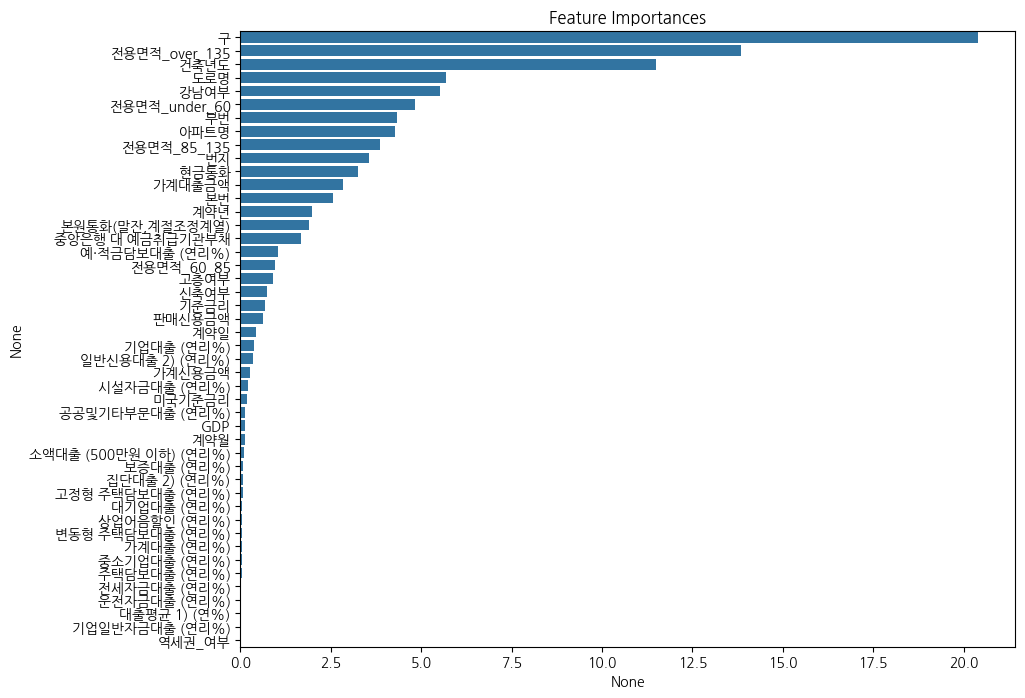

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model(6).pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [ ]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
2486887535.4631 ± 50910917.6527,구
1313369239.7159 ± 61568312.9061,건축년도
1200981571.7534 ± 39045456.4484,전용면적_over_135
1088346874.4038 ± 39246143.1371,강남여부
816454482.2621 ± 25503329.1824,전용면적_under_60
626467654.2149 ± 19516901.6195,도로명
530230346.3847 ± 14258980.5387,아파트명
369104765.8816 ± 21237634.0755,번지
345859080.3327 ± 24277760.1186,부번
320469011.5269 ± 4668822.6163,본번


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['predictions'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['predictions'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

,번지,본번,부번,아파트명,계약일,건축년도,도로명,역세권_여부,구,강남여부,...,고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월,target,predictions,error
204578,5938,1371,110,1768,12,1998,2605,False,14,1,...,0,0,0,0,1,16,5,640000.0,274943.442516,1.332663e+11
204579,5938,1371,110,1768,12,1998,2605,False,14,1,...,0,0,0,0,1,16,5,640000.0,274943.442516,1.332663e+11
222622,4859,1178,286,4056,26,2020,6844,False,15,0,...,1,0,0,0,1,16,2,620000.0,966672.800506,1.201820e+11
210814,224,45,0,3060,21,2008,2956,False,23,0,...,0,0,0,0,1,16,1,590000.0,283036.286691,9.422672e+10
204235,2486,720,140,5928,15,1971,7330,False,20,0,...,0,0,0,0,1,16,5,585000.0,281004.052300,9.241354e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,계약일,건축년도,도로명,역세권_여부,구,강남여부,...,고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월,target,predictions,error
204578,86-2,86.0,2.0,레베빌,12,1998,동광로39길 18,False,서초구,1,...,0,0,0,0,1,2023,06,640000.0,274943.442516,1.332663e+11


,번지,본번,부번,아파트명,계약일,건축년도,도로명,역세권_여부,구,강남여부,...,고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월,target,predictions,error
211772,1315,1315.0,0.0,진흥,7,1979,서초대로 385,False,서초구,1,...,0,0,0,1,0,2023,04,221000.0,221075.708452,5731.769712


- 이제 분포를 비교해보도록 하겠습니다.

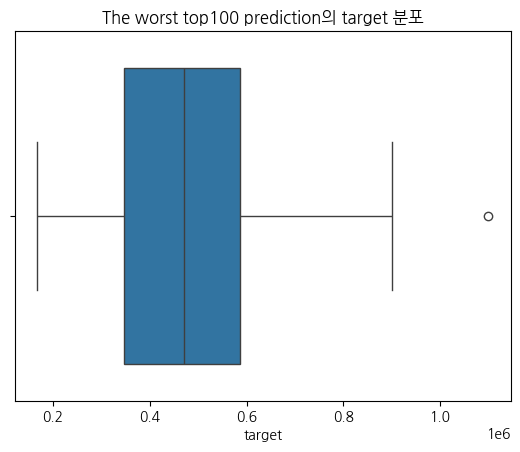

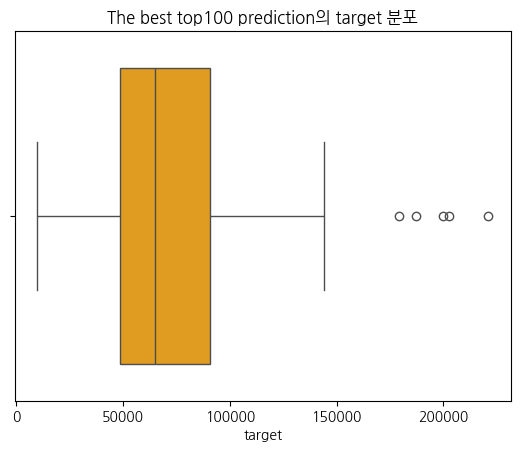

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,계약일,건축년도,도로명,target,역세권_여부,구,...,일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%),고층여부,전용면적_under_60,전용면적_60_85,전용면적_85_135,전용면적_over_135,계약년,계약월
0,4732,1148,1,330,26,1987,6176,0,False,0,...,7.21,4.79,5.2,0,0,1,0,0,16,6
1,4688,1138,0,402,26,1984,6169,0,False,0,...,7.21,4.79,5.2,0,0,0,0,1,16,6


In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model(6).pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 349 ms, sys: 4.41 ms, total: 354 ms
Wall time: 57.5 ms


In [ ]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([155552.14431678, 287571.30576423, 178973.18318158, ...,
        61904.81827834,  23680.950005  ,  35632.16607839])

## 7. Output File Save

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output(6).csv', index=False)

In [ ]:
preds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  9272 non-null   int64
dtypes: int64(1)
memory usage: 72.6 KB
